In [2]:
!pip install opendatasets

In [3]:
import opendatasets as od


#Import datset

In [4]:
od.download('https://www.kaggle.com/datasets/arjuntejaswi/plant-village?resource=download')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pradeeptechno
Your Kaggle Key: ··········


100%|██████████| 329M/329M [00:02<00:00, 120MB/s]


In [91]:
import tensorflow as tf
import keras
from keras import models,layers
import matplotlib.pyplot as plt
from math import floor
import numpy as np

In [36]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 30
CHANNELS = 3

#Preprocessing

In [37]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/plant-village/PlantVillage",
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = True
)
dataset

Found 5043 files belonging to 4 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [38]:
len_dataset = len(dataset)

Class Labels

In [39]:
CLASS_NAMES = dataset.class_names
CLASS_NAMES

['Tomato_Bacterial_spot',
 'Tomato_Leaf_Mold',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [40]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch[0].numpy().shape)
  print(label_batch[0].numpy())

(256, 256, 3)
0


#Visualize

1


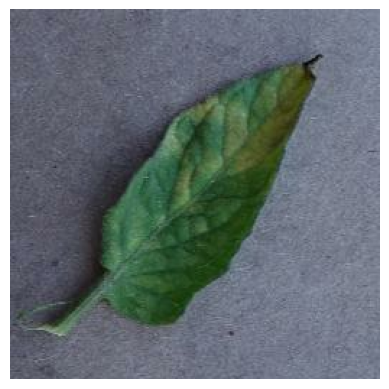

In [41]:
for image_batch,label_batch in dataset.take(1):
  img_arr = image_batch[0].numpy().astype('uint8')
  plt.imshow(img_arr)
  print(label_batch[0].numpy())
  plt.axis('off')

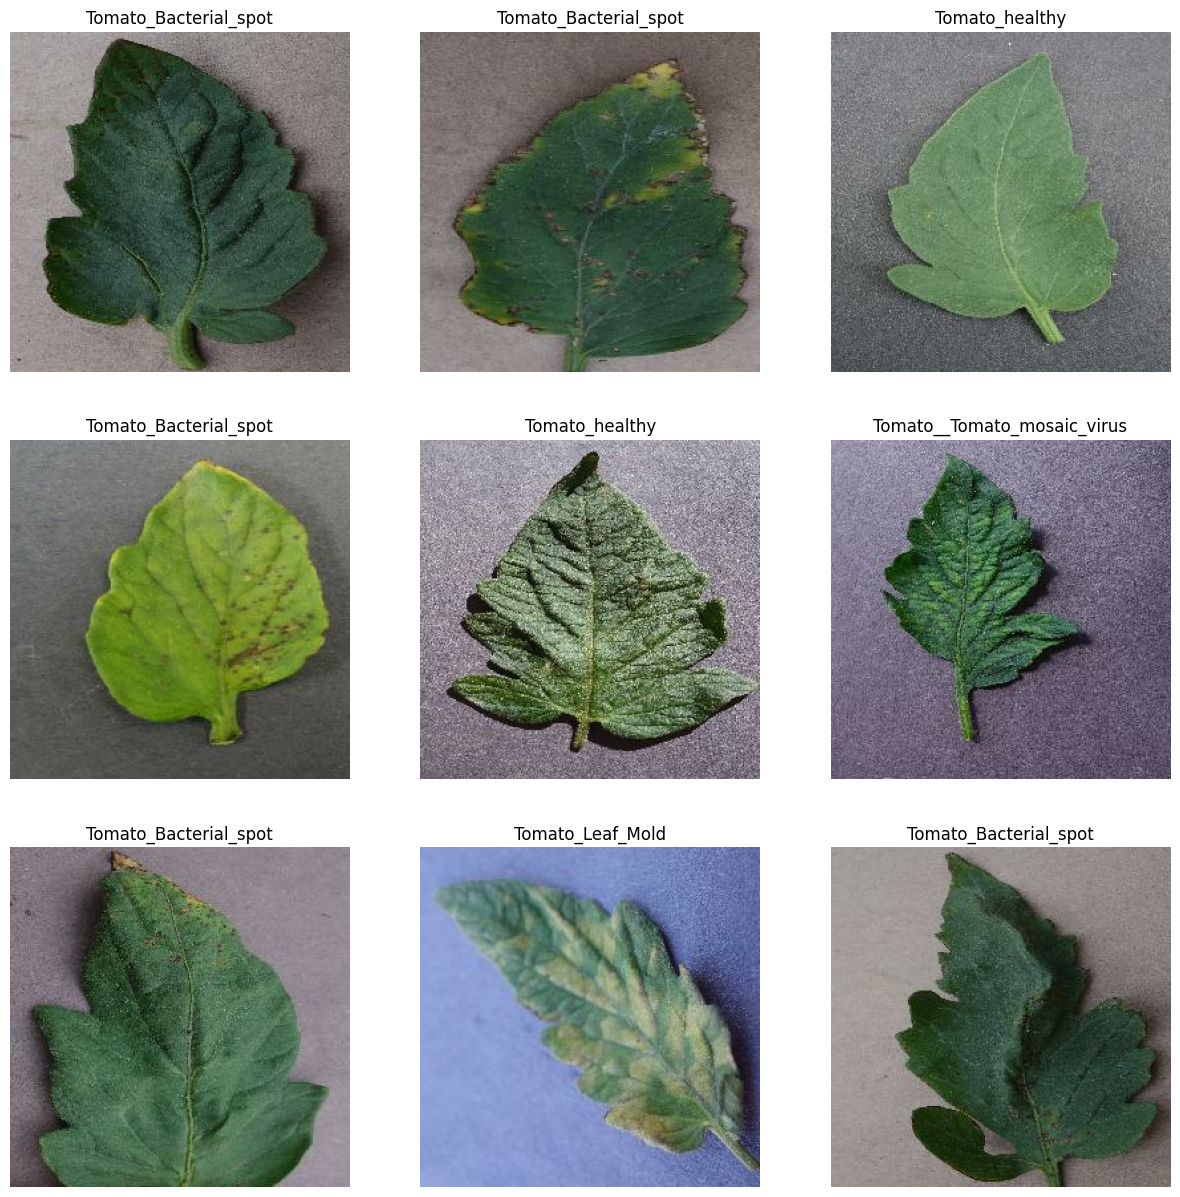

In [42]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in dataset.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    img_arr = image_batch[i].numpy().astype('uint8')
    plt.imshow(img_arr)
    plt.title(CLASS_NAMES[label_batch[i].numpy()])
    plt.axis('off')

#Split the dataset


In [43]:
#Train = 80%
#Val = 10%
#Test = 10%

In [44]:
def partition_data(ds,train=0.8,val=.1,test=.1):
  train_ds_size = floor(train*len_dataset)
  val_ds_size = floor(val*len_dataset)

  train_ds = dataset.take(train_ds_size)
  val_ds = dataset.skip(train_ds_size).take(val_ds_size)
  test_ds = dataset.skip(train_ds_size).skip(val_ds_size)
  return train_ds,val_ds,test_ds

In [45]:
train_ds,val_ds,test_ds = partition_data(dataset)

In [46]:
print(len(dataset),'\n',len(train_ds),len(val_ds),len(test_ds))

158 
 126 15 17


#Cache,shuffle,prefetch

In [47]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#Resize and Rescale

In [48]:
resize_rescale = tf.keras.models.Sequential()
resize_rescale.add(tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE))
resize_rescale.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255))

#Data Augmentation

In [49]:
data_aug = models.Sequential()
data_aug.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'))
data_aug.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))

#Model Architecture

In [50]:
INPUT_SHAPE = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

model = models.Sequential()
model.add(resize_rescale)
model.add(data_aug)
model.add(layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',input_shape=INPUT_SHAPE))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())


model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(4,activation='softmax'))
model.build(input_shape=INPUT_SHAPE)

In [51]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_5 (Conv2D)           (32, 254, 254, 16)        448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (32, 127, 127, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (32, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 62, 62, 32)          0         
 g2D)                                                 

In [52]:
model.compile(
    optimizer = 'adam',
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [53]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = val_ds,
    epochs = EPOCHS,
    verbose=1
)

Epoch 1/30
126/126 [==============================] - 15s 67ms/step - loss: 0.8769 - accuracy: 0.6260 - val_loss: 0.4597 - val_accuracy: 0.8562
Epoch 2/30
126/126 [==============================] - 5s 40ms/step - loss: 0.3298 - accuracy: 0.8728 - val_loss: 0.2027 - val_accuracy: 0.9292
Epoch 3/30
126/126 [==============================] - 5s 39ms/step - loss: 0.2121 - accuracy: 0.9201 - val_loss: 0.3471 - val_accuracy: 0.8896
Epoch 4/30
126/126 [==============================] - 5s 40ms/step - loss: 0.1652 - accuracy: 0.9444 - val_loss: 0.1247 - val_accuracy: 0.9563
Epoch 5/30
126/126 [==============================] - 5s 39ms/step - loss: 0.1329 - accuracy: 0.9536 - val_loss: 0.7503 - val_accuracy: 0.7542
Epoch 6/30
126/126 [==============================] - 5s 40ms/step - loss: 0.1075 - accuracy: 0.9628 - val_loss: 0.4835 - val_accuracy: 0.8917
Epoch 7/30
126/126 [==============================] - 5s 40ms/step - loss: 0.0978 - accuracy: 0.9660 - val_loss: 0.1241 - val_accuracy: 0.972

In [55]:
score = model.evaluate(test_ds)
score

17/17 [==============================] - 4s 51ms/step - loss: 0.1014 - accuracy: 0.9642


[0.10139381140470505, 0.9642184376716614]

In [56]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

#Evaluation

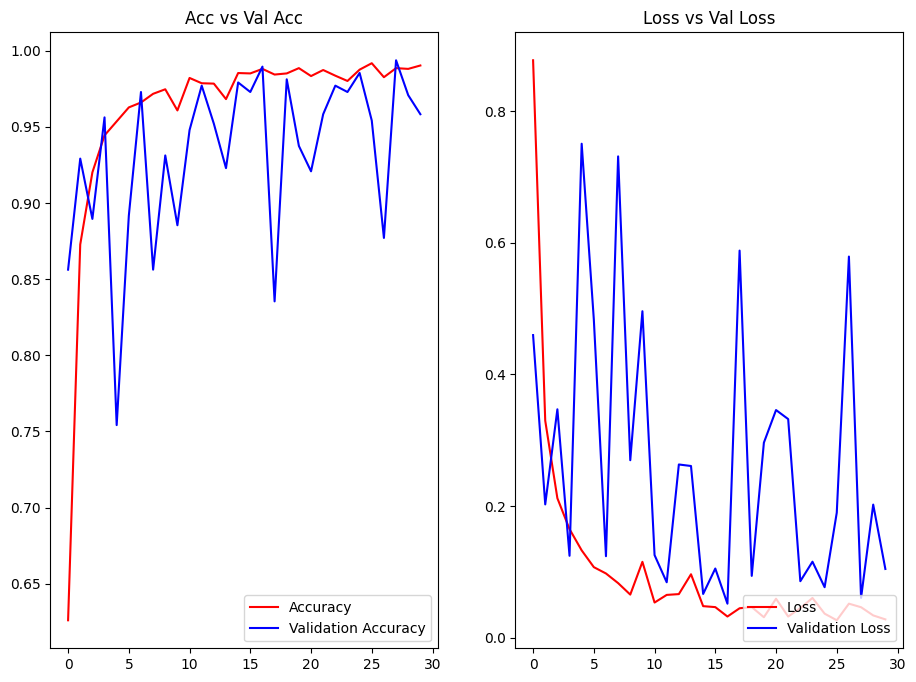

In [57]:
plt.figure(figsize = (11,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),history.history['accuracy'],c="red",label='Accuracy')
plt.plot(range(EPOCHS),history.history['val_accuracy'],c="blue",label='Validation Accuracy')

plt.legend(loc='lower right')
plt.title('Acc vs Val Acc')

plt.subplot(1,2,2)

plt.plot(range(EPOCHS),history.history['loss'],c="red",label='Loss')
plt.plot(range(EPOCHS),history.history['val_loss'],c="blue",label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Loss vs Val Loss')
plt.show()

#Testing first image

1/1 [==============================] - 0s 41ms/step
Predicted :  Tomato_Bacterial_spot
Actual :  Tomato_Bacterial_spot


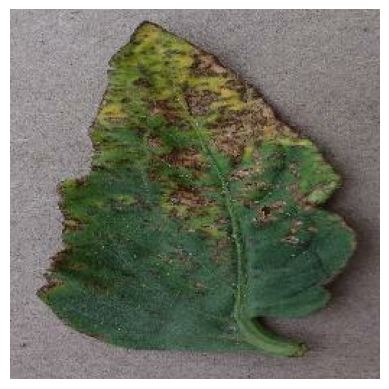

In [93]:
for image,label in test_ds.take(1):
  img_arr = image[0].numpy().astype('uint8')
  y_pred = model.predict(image)
  print('Predicted : ',CLASS_NAMES[np.argmax(y_pred[0])])
  print('Actual : ',CLASS_NAMES[label[0].numpy()])
  plt.imshow(img_arr)
  plt.axis('off')

#Testing with dataset

In [83]:
def prediction(model,img):
  img_arr = keras.preprocessing.image.img_to_array(img)
  img_arr = tf.expand_dims(img_arr,0)

  prediction1 = model.predict(img_arr)
  prediction_class = CLASS_NAMES[np.argmax(prediction1[0])]
  confidence = round(100*np.max(prediction1[0]),2)
  return prediction_class,confidence


1/1 [==============================] - 0s 18ms/step


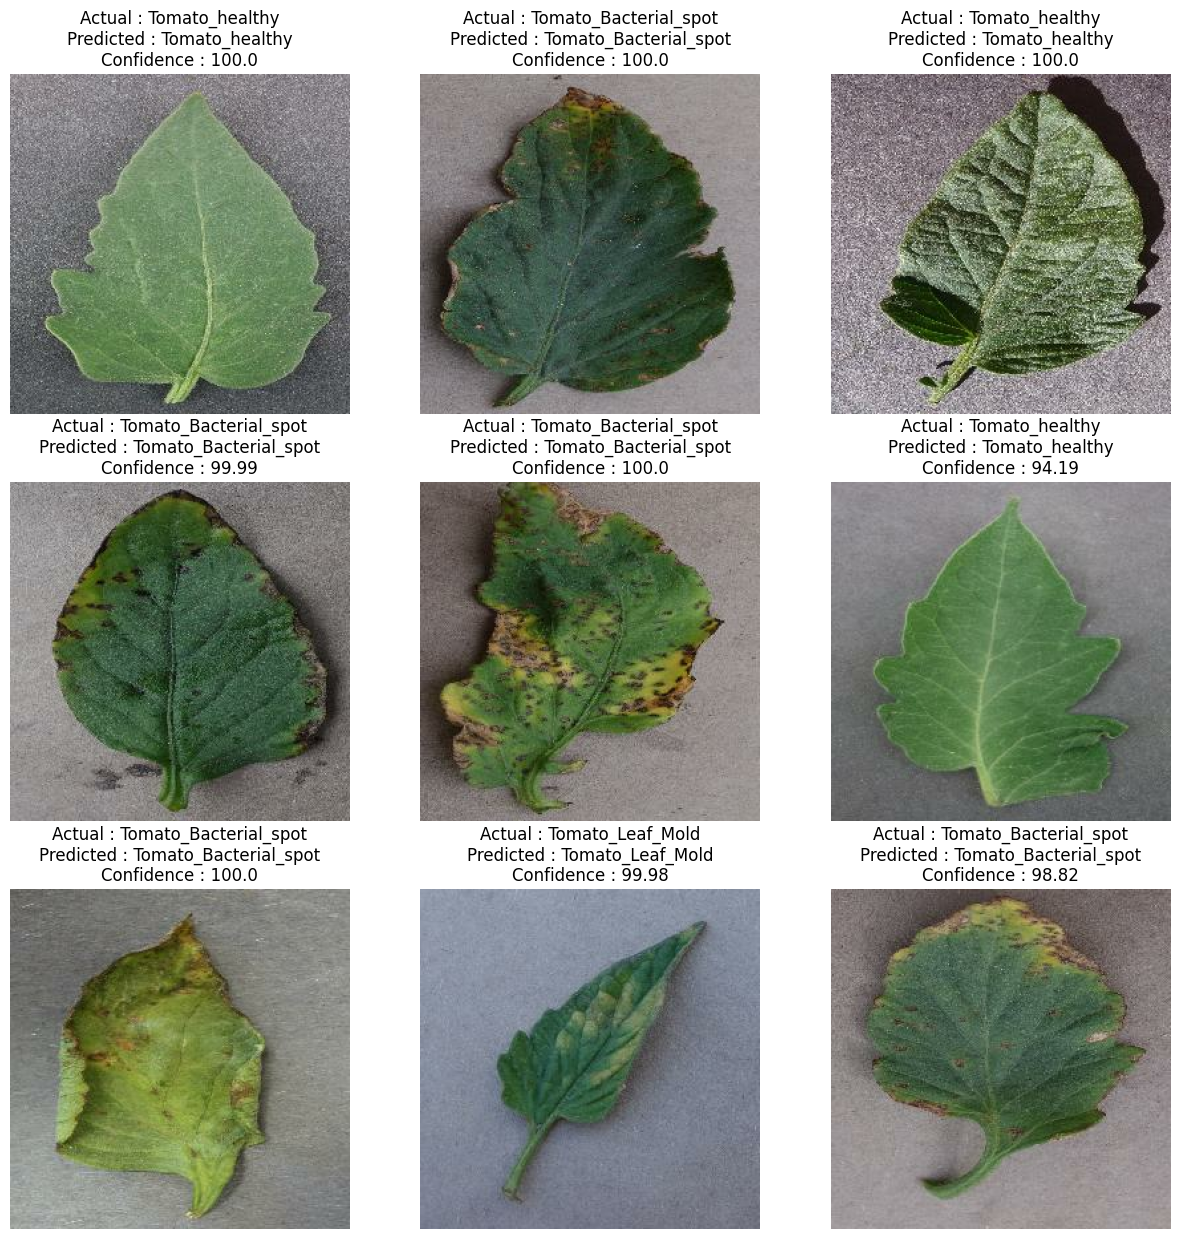

In [90]:
plt.figure(figsize=(15,15))
for image_batch,label_batch in test_ds.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.axis('off')
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    y_pred,confidence = prediction(model,image_batch[i].numpy())
    plt.title('Actual : '+str(CLASS_NAMES[label_batch[i].numpy()])+'\n'+'Predicted : '+str(y_pred)+'\n'+'Confidence : '+str(confidence))


